In [1]:
import torchvision
import numpy as np
import torch
import sklearn as sk
import PIL
import pickle

from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt

In [2]:
from google.colab import drive, files
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
#!kaggle datasets download -d devzohaib/dog-emotions-prediction
!unzip -u -q /content/gdrive/MyDrive/1.zip
#None

In [5]:
from torch.utils.data.dataset import random_split
transformer = transforms.Compose ([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
n_classes = 4 # Count of classified classes
dataset = torchvision.datasets.ImageFolder(root = '/content/1/images', transform = transformer)
all_samples = len(dataset)
train_count = int(0.7 * all_samples)
valid_count = all_samples - train_count
train_dataset, valid_dataset = random_split(dataset, [train_count, valid_count])

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Новый раздел

# Новый раздел

In [7]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

In [8]:
class SimpleCNN (nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.fc = nn.Sequential(
        nn.Linear(in_features = 2400, out_features = 1200, bias = True),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = 1200, out_features = 600, bias = True),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = 600, out_features = 100, bias = True),
        nn.ReLU()
    )
    self.out = nn.Linear(in_features = 100, out_features = n_classes)
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(x.size(0), -1)
    print(x.shape)
    x = self.fc(x)
    logits = self.out(x)
    return logits

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [10]:
def fit_epoch(model, train_loader, crit, opt):
  model.train()
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    opt.zero_grad()
    outputs = model(x)
    loss = crit(outputs, y)
    loss.backward()
    opt.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * x.size(0)
    running_corrects += torch.sum(preds == y.data)
    processed_data += x.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
  return val_loss, val_acc

In [12]:
def train(train_loader, val_loader, model, epochs, batch_size, scheduler = False):
    global SCH_STEP, GAMMA
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
        criterion = nn.CrossEntropyLoss()
        if scheduler:
          sch = torch.optim.lr_scheduler.StepLR(optimizer = opt, step_size = SCH_STEP, gamma = GAMMA)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if scheduler:
              sch.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [14]:
net = SimpleCNN(n_classes)
SCH_STEP = 2
GAMMA = 0.8

In [15]:
history = train(train_loader, valid_loader, net.to(device), 16, BATCH_SIZE, True)

epoch:   0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size(

epoch:   6%|▋         | 1/16 [01:04<16:03, 64.25s/it]

torch.Size([18, 2400])

Epoch 001 train_loss: 1.2588     val_loss 1.2514 train_acc 0.3200 val_acc 0.2975
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  12%|█▎        | 2/16 [02:00<13:51, 59.42s/it]


Epoch 002 train_loss: 1.2507     val_loss 1.2414 train_acc 0.3223 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  19%|█▉        | 3/16 [02:55<12:27, 57.50s/it]

torch.Size([18, 2400])

Epoch 003 train_loss: 1.2478     val_loss 1.2415 train_acc 0.3269 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  25%|██▌       | 4/16 [03:53<11:32, 57.70s/it]

torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 004 train_loss: 1.2479     val_loss 1.2425 train_acc 0.3277 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  31%|███▏      | 5/16 [04:50<10:30, 57.30s/it]

torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 005 train_loss: 1.2459     val_loss 1.2440 train_acc 0.3235 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  38%|███▊      | 6/16 [05:47<09:31, 57.19s/it]

torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 006 train_loss: 1.2455     val_loss 1.2415 train_acc 0.3324 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  44%|████▍     | 7/16 [06:42<08:30, 56.72s/it]

torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 007 train_loss: 1.2463     val_loss 1.2440 train_acc 0.3273 val_acc 0.2975
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  50%|█████     | 8/16 [07:38<07:32, 56.51s/it]


Epoch 008 train_loss: 1.2471     val_loss 1.2417 train_acc 0.3249 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  56%|█████▋    | 9/16 [08:34<06:33, 56.20s/it]

torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 009 train_loss: 1.2457     val_loss 1.2429 train_acc 0.3241 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  62%|██████▎   | 10/16 [09:30<05:36, 56.06s/it]

torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 010 train_loss: 1.2446     val_loss 1.2420 train_acc 0.3349 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  69%|██████▉   | 11/16 [10:26<04:40, 56.07s/it]

torch.Size([18, 2400])

Epoch 011 train_loss: 1.2453     val_loss 1.2415 train_acc 0.3314 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  75%|███████▌  | 12/16 [11:20<03:42, 55.60s/it]

torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 012 train_loss: 1.2442     val_loss 1.2419 train_acc 0.3335 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  81%|████████▏ | 13/16 [12:16<02:46, 55.50s/it]

torch.Size([18, 2400])

Epoch 013 train_loss: 1.2455     val_loss 1.2418 train_acc 0.3344 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  88%|████████▊ | 14/16 [13:12<01:51, 55.67s/it]

torch.Size([32, 2400])
torch.Size([18, 2400])

Epoch 014 train_loss: 1.2444     val_loss 1.2413 train_acc 0.3318 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch:  94%|█████████▍| 15/16 [14:06<00:55, 55.38s/it]

torch.Size([18, 2400])

Epoch 015 train_loss: 1.2445     val_loss 1.2425 train_acc 0.3342 val_acc 0.3399
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400])
torch.Size([32, 2400]

epoch: 100%|██████████| 16/16 [15:01<00:00, 56.32s/it]

torch.Size([18, 2400])

Epoch 016 train_loss: 1.2448     val_loss 1.2419 train_acc 0.3344 val_acc 0.3399


Тут lr 1e-3, step_size шедулера 2, гамма 0.8, 16 эпох.

In [16]:
def plot_losses(history):
  loss, acc, val_loss, val_acc = zip(*history)
  plt.figure(figsize=(15, 9))
  plt.plot(loss, label="train_loss")
  plt.plot(val_loss, label="val_loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

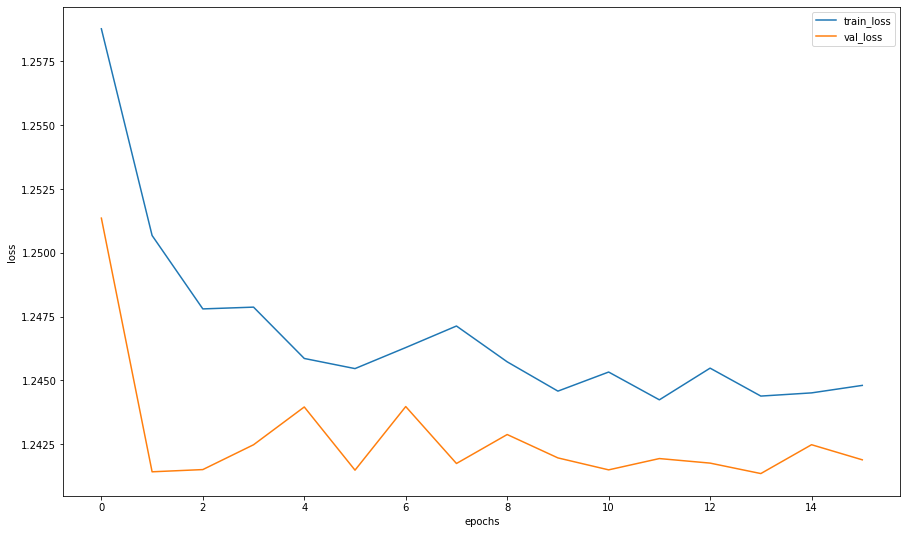

In [17]:
plot_losses(history)

In [18]:
class ReworkCNN (nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.fc = nn.Sequential(
        nn.Linear(in_features = 9216, out_features = 6144, bias = True),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = 6144, out_features = 4096, bias = True),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = 4096, out_features = 2048, bias = True),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = 2048, out_features = 1024, bias = True),
        nn.ReLU()
    )
    self.out = nn.Linear(in_features = 1024, out_features = n_classes)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    logits = self.out(x)
    return logits

In [19]:
#net1 = ReworkCNN(n_classes)
SCH_STEP = 4
GAMMA = 0.9
#history = history = train(train_loader, valid_loader, net1.to(device), 20, BATCH_SIZE, True)

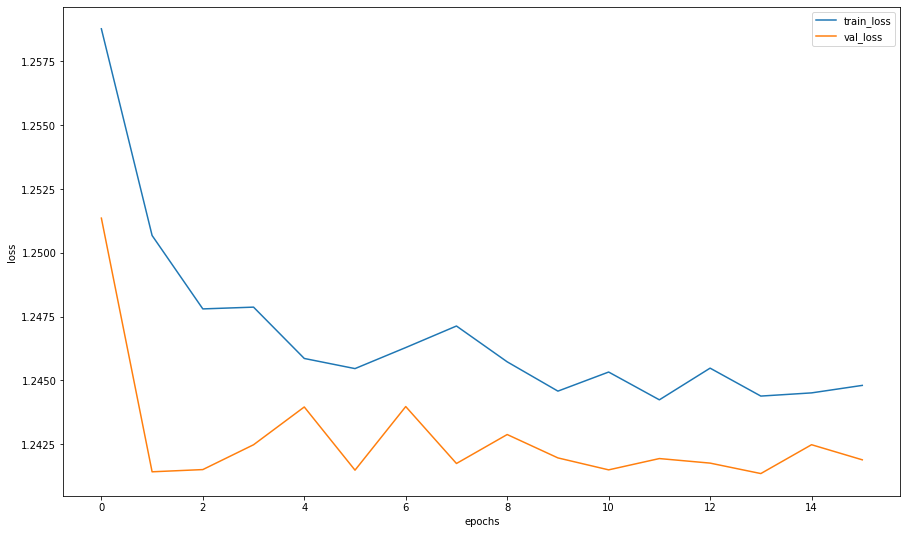

In [20]:
plot_losses(history)

In [21]:
from torchvision import models
alex = models.alexnet(pretrained = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [22]:
for param in alex.parameters():
  param.requires_grad = False

alex.classifier.add_module(name = '7', module = nn.ReLU())
alex.classifier.add_module(name = '8', module = nn.Linear(in_features = 1000, out_features = n_classes))

In [23]:
history = train(train_loader, valid_loader, alex.to(device), 16, BATCH_SIZE, True)

epoch:   0%|          | 0/16 [00:00<?, ?it/s]

loss 1.2286073820411914


epoch:   6%|▋         | 1/16 [01:09<17:25, 69.69s/it]


Epoch 001 train_loss: 1.2286     val_loss 1.0849 train_acc 0.4698 val_acc 0.5227
loss 1.1055941638591384


epoch:  12%|█▎        | 2/16 [02:26<17:17, 74.10s/it]


Epoch 002 train_loss: 1.1056     val_loss 1.0736 train_acc 0.5246 val_acc 0.5357
loss 1.0893259250385732


epoch:  19%|█▉        | 3/16 [03:37<15:44, 72.67s/it]


Epoch 003 train_loss: 1.0893     val_loss 1.0853 train_acc 0.5331 val_acc 0.5331
loss 1.0743181570809484


epoch:  25%|██▌       | 4/16 [04:48<14:24, 72.06s/it]


Epoch 004 train_loss: 1.0743     val_loss 1.0606 train_acc 0.5453 val_acc 0.5468
loss 1.0393568992852305


epoch:  31%|███▏      | 5/16 [06:04<13:27, 73.45s/it]


Epoch 005 train_loss: 1.0394     val_loss 1.0726 train_acc 0.5586 val_acc 0.5320
loss 1.0289341250812893


epoch:  38%|███▊      | 6/16 [07:12<11:54, 71.48s/it]


Epoch 006 train_loss: 1.0289     val_loss 1.1044 train_acc 0.5567 val_acc 0.5514
loss 1.0440419686807167


epoch:  44%|████▍     | 7/16 [08:21<10:36, 70.72s/it]


Epoch 007 train_loss: 1.0440     val_loss 1.1587 train_acc 0.5510 val_acc 0.5206
loss 1.0410093204038855


epoch:  50%|█████     | 8/16 [09:21<08:57, 67.22s/it]


Epoch 008 train_loss: 1.0410     val_loss 1.0498 train_acc 0.5547 val_acc 0.5555
loss 1.024328928174021


epoch:  56%|█████▋    | 9/16 [10:36<08:08, 69.80s/it]


Epoch 009 train_loss: 1.0243     val_loss 1.1172 train_acc 0.5513 val_acc 0.5198
loss 1.0143468734900019


epoch:  62%|██████▎   | 10/16 [11:45<06:57, 69.52s/it]


Epoch 010 train_loss: 1.0143     val_loss 1.0963 train_acc 0.5648 val_acc 0.5439
loss 0.9999170345436934


epoch:  69%|██████▉   | 11/16 [12:57<05:50, 70.06s/it]


Epoch 011 train_loss: 0.9999     val_loss 1.0775 train_acc 0.5732 val_acc 0.5415
loss 0.9983685494642178


epoch:  75%|███████▌  | 12/16 [13:59<04:30, 67.73s/it]


Epoch 012 train_loss: 0.9984     val_loss 1.1457 train_acc 0.5733 val_acc 0.5139
loss 0.9937006199786013


epoch:  81%|████████▏ | 13/16 [15:05<03:21, 67.24s/it]


Epoch 013 train_loss: 0.9937     val_loss 1.0672 train_acc 0.5650 val_acc 0.5404
loss 0.989699501165166


epoch:  88%|████████▊ | 14/16 [16:15<02:16, 68.10s/it]


Epoch 014 train_loss: 0.9897     val_loss 1.0601 train_acc 0.5759 val_acc 0.5593
loss 0.9851446675696013


epoch:  94%|█████████▍| 15/16 [17:27<01:09, 69.15s/it]


Epoch 015 train_loss: 0.9851     val_loss 1.0510 train_acc 0.5774 val_acc 0.5558
loss 0.9840055159367932


epoch: 100%|██████████| 16/16 [18:35<00:00, 69.70s/it]


Epoch 016 train_loss: 0.9840     val_loss 1.0693 train_acc 0.5758 val_acc 0.5410


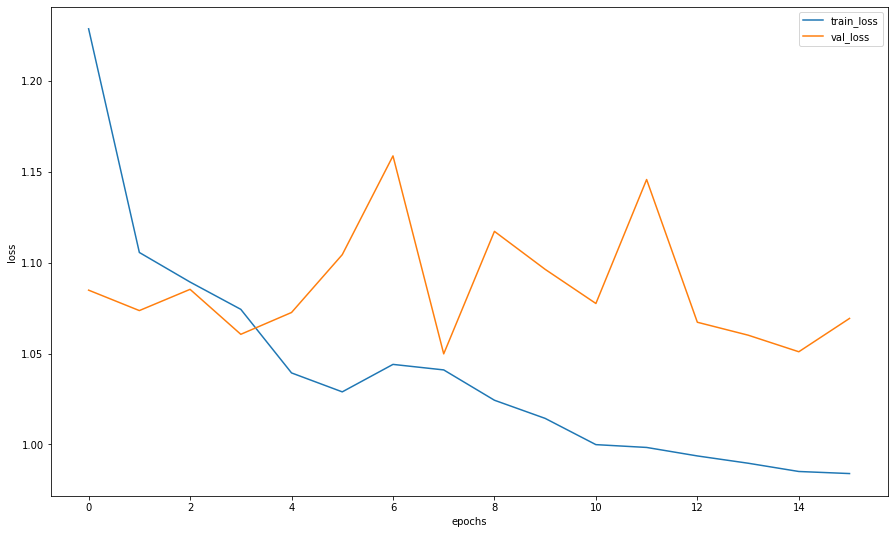

In [24]:
plot_losses(history)

In [25]:
resnet = models.resnet50(pretrained = True)

for param in resnet.parameters():
  param.requires_grad = False

resnet.fc = nn.Sequential (
    nn.Linear(in_features = 2048, out_features = 1024, bias = True),
    nn.ReLU(),
    nn.Linear(in_features = 1024, out_features = 128, bias = True),
    nn.ReLU(),
    nn.Linear(in_features = 128, out_features = 4, bias = True)
)
resnet

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

слой ...
модуль ...

In [26]:
history = train(train_loader, valid_loader, resnet.to(device), 20, BATCH_SIZE, True)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.0738856936617618


epoch:   5%|▌         | 1/20 [00:57<18:03, 57.04s/it]


Epoch 001 train_loss: 1.0739     val_loss 0.9977 train_acc 0.5153 val_acc 0.5767
loss 0.9713569769364601


epoch:  10%|█         | 2/20 [01:54<17:08, 57.11s/it]


Epoch 002 train_loss: 0.9714     val_loss 1.0072 train_acc 0.5768 val_acc 0.5721
loss 0.9269676442935586


epoch:  15%|█▌        | 3/20 [02:51<16:09, 57.04s/it]


Epoch 003 train_loss: 0.9270     val_loss 0.9265 train_acc 0.6075 val_acc 0.6252
loss 0.8887242966206615


epoch:  20%|██        | 4/20 [03:47<15:08, 56.81s/it]


Epoch 004 train_loss: 0.8887     val_loss 0.9655 train_acc 0.6191 val_acc 0.5773
loss 0.8838583875124119


epoch:  25%|██▌       | 5/20 [04:44<14:13, 56.87s/it]


Epoch 005 train_loss: 0.8839     val_loss 0.9191 train_acc 0.6193 val_acc 0.6264
loss 0.8742225704417013


epoch:  30%|███       | 6/20 [05:40<13:13, 56.68s/it]


Epoch 006 train_loss: 0.8742     val_loss 0.9196 train_acc 0.6249 val_acc 0.6273
loss 0.8600795534705593


epoch:  35%|███▌      | 7/20 [06:39<12:25, 57.34s/it]


Epoch 007 train_loss: 0.8601     val_loss 0.9082 train_acc 0.6285 val_acc 0.6284
loss 0.8329003788581865


epoch:  40%|████      | 8/20 [07:38<11:32, 57.71s/it]


Epoch 008 train_loss: 0.8329     val_loss 0.9382 train_acc 0.6432 val_acc 0.6203
loss 0.8126814075492658


epoch:  45%|████▌     | 9/20 [08:35<10:34, 57.68s/it]


Epoch 009 train_loss: 0.8127     val_loss 0.9518 train_acc 0.6543 val_acc 0.6113
loss 0.7985523233587113


epoch:  50%|█████     | 10/20 [09:32<09:33, 57.38s/it]


Epoch 010 train_loss: 0.7986     val_loss 0.9110 train_acc 0.6546 val_acc 0.6238
loss 0.7951640996426392


epoch:  55%|█████▌    | 11/20 [10:30<08:37, 57.49s/it]


Epoch 011 train_loss: 0.7952     val_loss 0.9803 train_acc 0.6615 val_acc 0.6104
loss 0.763004210613216


epoch:  60%|██████    | 12/20 [11:28<07:42, 57.81s/it]


Epoch 012 train_loss: 0.7630     val_loss 0.9383 train_acc 0.6779 val_acc 0.6209
loss 0.7512009764448141


epoch:  65%|██████▌   | 13/20 [12:26<06:45, 57.94s/it]


Epoch 013 train_loss: 0.7512     val_loss 0.9656 train_acc 0.6785 val_acc 0.6194
loss 0.7406918163806746


epoch:  70%|███████   | 14/20 [13:27<05:52, 58.72s/it]


Epoch 014 train_loss: 0.7407     val_loss 0.9482 train_acc 0.6770 val_acc 0.6092
loss 0.7058156433802106


epoch:  75%|███████▌  | 15/20 [14:28<04:56, 59.30s/it]


Epoch 015 train_loss: 0.7058     val_loss 0.9538 train_acc 0.6967 val_acc 0.6232
loss 0.7062630314342349


epoch:  80%|████████  | 16/20 [15:27<03:57, 59.27s/it]


Epoch 016 train_loss: 0.7063     val_loss 0.9770 train_acc 0.6946 val_acc 0.6153
loss 0.6841664406768945


epoch:  85%|████████▌ | 17/20 [16:26<02:57, 59.29s/it]


Epoch 017 train_loss: 0.6842     val_loss 1.0029 train_acc 0.7048 val_acc 0.6031
loss 0.6600349636418775


epoch:  90%|█████████ | 18/20 [17:24<01:57, 58.90s/it]


Epoch 018 train_loss: 0.6600     val_loss 0.9987 train_acc 0.7143 val_acc 0.6145
loss 0.633568031321072


epoch:  95%|█████████▌| 19/20 [18:22<00:58, 58.70s/it]


Epoch 019 train_loss: 0.6336     val_loss 1.0303 train_acc 0.7284 val_acc 0.6063
loss 0.6344114886539961


epoch: 100%|██████████| 20/20 [19:23<00:00, 58.15s/it]


Epoch 020 train_loss: 0.6344     val_loss 1.0332 train_acc 0.7257 val_acc 0.6232


In [27]:
from google.colab import drive, files
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [36]:
from torchvision.transforms.transforms import Normalize
img = Image.open('/content/gdrive/MyDrive/10.jpg')
from torch.utils.data.dataset import random_split
transformer = transforms.Compose ([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
img_tensor = transformer(img)
print(img_tensor.size())

img_tensor = img_tensor.to(device)
print(img_tensor.size())
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.size())


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [37]:
resnet(img_tensor)

tensor([[-3.5178,  2.4880,  2.4198, -4.4122]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

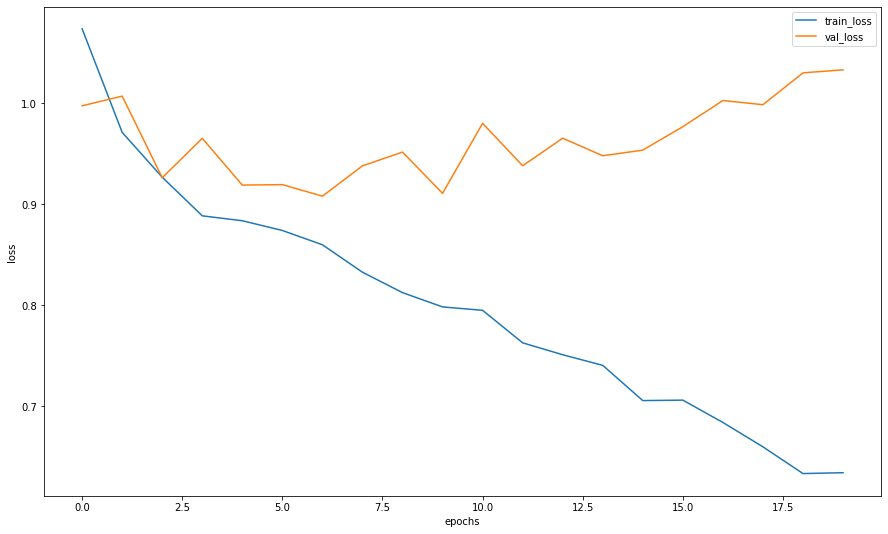

In [34]:
plot_losses(history)